In [1]:
import numpy as np
import pylab as plt
import svgwrite
from skimage import io, filters, measure, feature, exposure, morphology
from scipy import ndimage, spatial
from scipy.ndimage import rotate
import os
import random
from IPython.display import SVG
%matplotlib inline

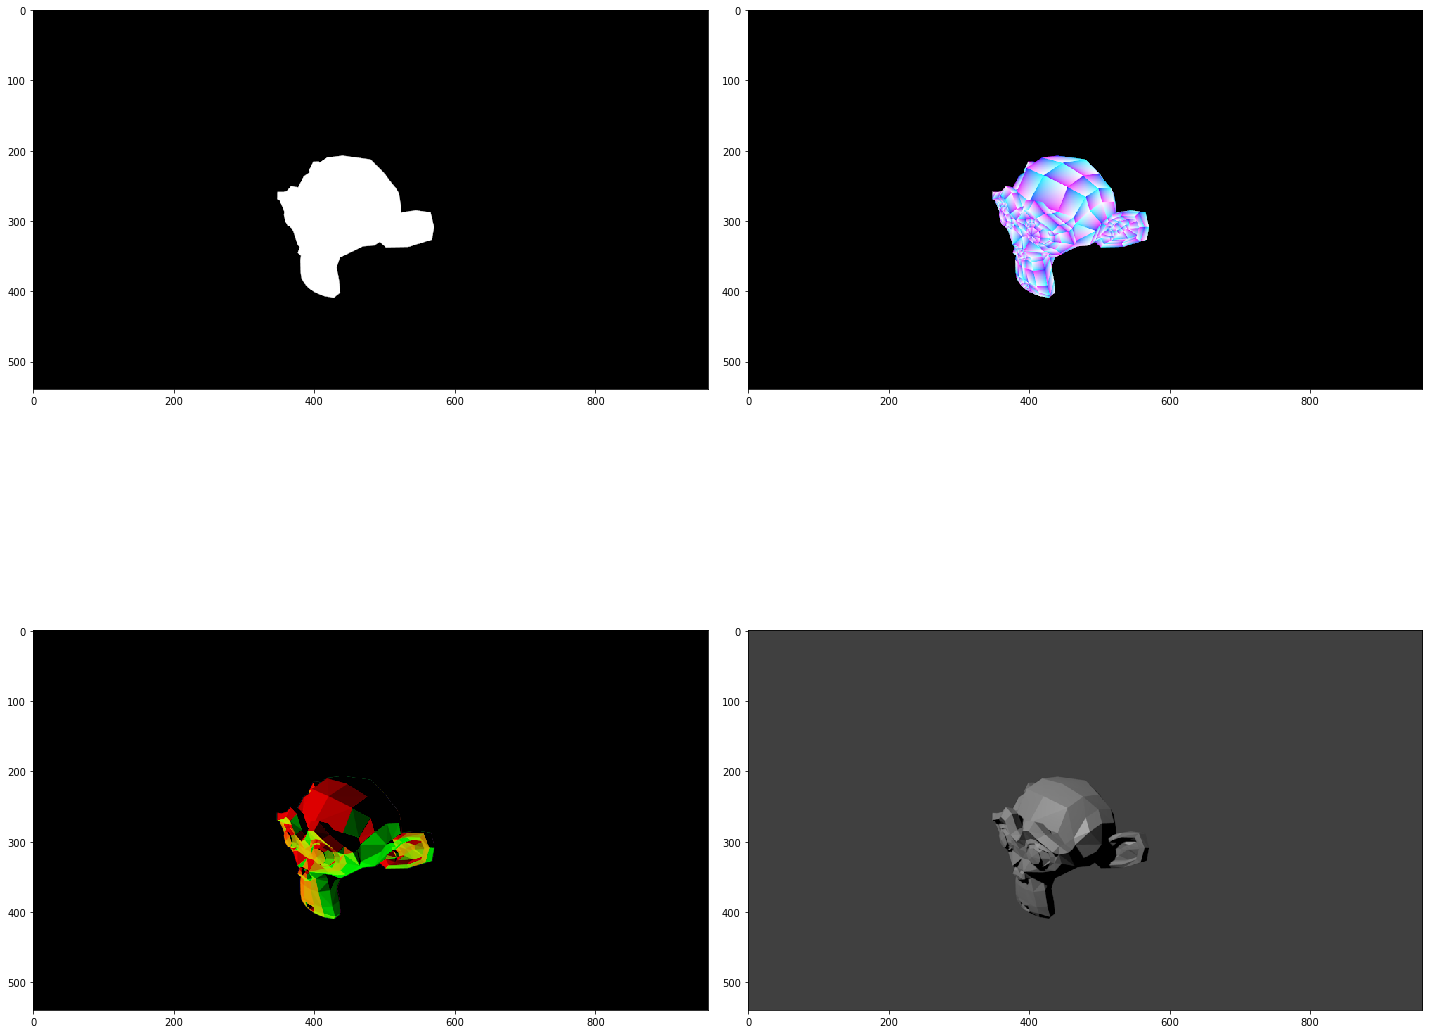

In [2]:
ao_monkey = io.imread('TestMonkey/AO.png')
uv_monkey = io.imread('TestMonkey/UV.png')
normal_monkey = io.imread('TestMonkey/Normal.png')
original_monkey = io.imread('TestMonkey/Original.png')

fig=plt.figure(figsize=(20, 20))

fig.add_subplot(2, 2, 1)
plt.imshow(ao_monkey)
fig.add_subplot(2, 2, 2)
plt.imshow(uv_monkey)
fig.add_subplot(2, 2, 3)
plt.imshow(normal_monkey)
fig.add_subplot(2, 2, 4)
plt.imshow(original_monkey)
fig.tight_layout()

[[213 414]
 [220 396]
 [234 389]
 [242 506]
 [244 381]
 [256 517]
 [259 358]
 [288 527]
 [291 566]
 [303 359]
 [311 367]
 [333 489]
 [336 377]
 [338 502]
 [339 464]
 [387 384]
 [398 394]
 [406 432]]


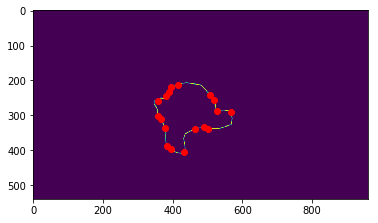

In [3]:
edge_monkey = filters.sobel(ao_monkey[:,:,0])
coords = feature.corner_peaks(feature.corner_fast(edge_monkey), min_distance=5)
print(coords)
plt.figure()
plt.plot(coords[:,1],coords[:,0],"ro")
plt.imshow(edge_monkey)

In [4]:
def center_angle(p1, p2):
    x_difference = p2[1]-p1[1]
    y_difference = p2[0]-p1[0]
    return np.rad2deg(np.arctan2(y_difference, x_difference))

[[213 414]] [[333 489]
 [338 502]
 [339 464]
 [336 377]
 [406 432]
 [387 384]
 [398 394]
 [259 358]
 [220 396]
 [234 389]
 [244 381]
 [213 414]
 [242 506]
 [256 517]
 [303 359]
 [288 527]
 [291 566]
 [311 367]]


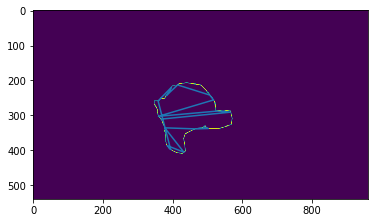

In [5]:
mean_x = np.mean(coords[1,:])
mean_y = np.mean(coords[0,:])
mean_point = [mean_y, mean_x]

start = coords[np.where(spatial.distance.cdist([[0, 0]], coords).max())]
angles = []
for i in coords:
    angles.append(center_angle(i, mean_point))

angles = np.asarray(angles)
coords = coords[angles.argsort()]
print(start, coords)
plt.figure()
plt.plot(coords[:,1],coords[:,0],)
plt.imshow(edge_monkey)

In [6]:
dwg = svgwrite.Drawing('stroke.svg')

dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), rx=None, ry=None, fill='white'))

for i in range(0,10):
    genid = chr(i+48)
    gradline = dwg.linearGradient((0, 0), (1, 0), id=genid)
    gradline.add_stop_color(1, 'white', 0)
    gradline.add_stop_color(round(random.uniform(0.85, 0.95), 2), 'black')

    dwg.defs.add(gradline)
    
    start_x = random.randint(10, 100)
    start_y = random.randint(10, 100)
    
    dwg.add(dwg.line((start_x, start_y),
                     (start_x + random.randint(25, 100), start_y + random.randint(25, 100)),
                     stroke="url(#" + genid + ")",
                     stroke_linecap="round"))

display(SVG(dwg.tostring().replace('><','>\n<')))

dwg.save()

In [53]:
def sketch(points, name):
    precision = 5
    dwg = svgwrite.Drawing(name)
    
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), rx=None, ry=None, fill='white'))
    
    gradline = dwg.linearGradient((0, 0), (1, 0), id="grad")
    #gradline.add_stop_color(1, 'white', 0.1)
    gradline.add_stop_color(1, 'black')
    
    dwg.defs.add(gradline)
    
    for i in range(1, len(points)):
        dwg.add(dwg.line((round(points[i-1][0], precision),(round(points[i-1][1], precision))),
                         ((round(points[i][0], precision), (round(points[i][1], precision)))),
                         stroke="url(#grad)",
                         stroke_linecap="round"))

    display(SVG(dwg.tostring().replace('><','>\n<')))

    return dwg

In [54]:
edge_monkey = filters.sobel(ao_monkey[:,:,0] + normal_monkey[:,:,0])
new_edge_monkey =np.flip(np.rot90(edge_monkey), axis=0)
contours = measure.find_contours(new_edge_monkey, 0.17, fully_connected="high")
simplified_contours = [measure.approximate_polygon(c, tolerance=0) for c in contours]
svg = sketch(simplified_contours[0], 'sketch.svg')
svg.save()

In [9]:
def path_sketches(points):
    precision = 5
    dwg = svgwrite.Drawing('path1.svg')

    gradline = dwg.linearGradient((0, 0), (1, 0), id="grad")
    gradline.add_stop_color(1, 'white', 0.8)
    gradline.add_stop_color(0.9, 'black')
    
    dwg.defs.add(gradline)
    
    path = dwg.path(('M', points[0][0,0], points[0][0,1]), fill='black', stroke='black')
    for pointSet in points:
        path.push('M', pointSet[0,0], pointSet[0,1])
        for p in pointSet[1:]:
            path.push(('L', p[0], p[1]))
    
    dwg.add(path)
    
    return dwg

In [10]:
path_out = path_sketches(simplified_contours)
path_out.save()

In [11]:
def angle(p1):
    ang = np.arctan2(p1[0], p1[1])
    return np.rad2deg((ang) % (2 * np.pi))

In [55]:
def path_sketch(points, corners=[]):
    corners[:,[0,1]] = corners[:,[1,0]]
    dwg = svgwrite.Drawing('path1.svg')
    
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), rx=None, ry=None, fill='white'))

    gradline = dwg.linearGradient((0, 0), (0, 0), id="grad")
    gradline.add_stop_color(0.1, 'white')
    gradline.add_stop_color(1, 'black')
    
    dwg.defs.add(gradline)
    
    path = dwg.path(('M', points[0,0], points[0,1]), fill='none', stroke='black')
    for i in range(1, len(points)):
        path.push(('L', points[i,0], points[i,1]))
        print(points[i-1], points[i])
        if points[i] in corners:
            dwg.add(dwg.line((points[i,0],points[i,1]),
                             (points[i,0]+(points[i,0]-points[i-1,0])*2.5, points[i,1]+(points[i,1]-points[i-1,1])*2.5),
                             stroke='black',
                             stroke_width=round(random.uniform(0.6, 0.85), 2),
                             stroke_linecap='round'))
            
            dwg.add(dwg.line((points[i,0],points[i,1]),
                             (points[i,0]+(points[i,0]-points[i+1,0])*2.5, points[i,1]+(points[i,1]-points[i+1,1])*2.5),
                             stroke='black',
                             stroke_width=round(random.uniform(0.6, 0.85), 2),
                             stroke_linecap='round'))
    
    dwg.add(path)
    
    return dwg

In [56]:
path_out = path_sketch(simplified_contours[0], feature.corner_peaks(feature.corner_fast(edge_monkey), min_distance=20))
path_out.save()

[571.24235372 311.        ] [571.49008639 310.        ]
[571.49008639 310.        ] [571.48169031 309.        ]
[571.48169031 309.        ] [571.21014285 308.        ]
[571.21014285 308.        ] [571.         307.66865892]
[571.         307.66865892] [570.84396324 307.        ]
[570.84396324 307.        ] [570.79712524 306.        ]
[570.79712524 306.        ] [570.74756994 305.        ]
[570.74756994 305.        ] [570.48022377 304.        ]
[570.48022377 304.        ] [570.         303.36440627]
[570.         303.36440627] [569.87328271 303.        ]
[569.87328271 303.        ] [569.80111403 302.        ]
[569.80111403 302.        ] [569.77421888 301.        ]
[569.77421888 301.        ] [569.62532663 300.        ]
[569.62532663 300.        ] [569.31252553 299.        ]
[569.31252553 299.        ] [569.         298.37058694]
[569.         298.37058694] [568.91093697 298.        ]
[568.91093697 298.        ] [568.77641057 297.        ]
[568.77641057 297.        ] [568.62532663 296.  

[352.57019733 281.        ] [352.98522727 282.        ]
[352.98522727 282.        ] [353.         282.01477273]
[353.         282.01477273] [353.41678357 283.        ]
[353.41678357 283.        ] [353.74099858 284.        ]
[353.74099858 284.        ] [354.         284.26123411]
[354.         284.26123411] [354.52038997 285.        ]
[354.52038997 285.        ] [354.52491256 286.        ]
[354.52491256 286.        ] [354.82161642 287.        ]
[354.82161642 287.        ] [355.         287.19809474]
[355.         287.19809474] [355.43493144 288.        ]
[355.43493144 288.        ] [355.43866133 289.        ]
[355.43866133 289.        ] [355.26898738 290.        ]
[355.26898738 290.        ] [355.         290.84025051]
[355.         290.84025051] [354.88338412 291.        ]
[354.88338412 291.        ] [354.64874241 292.        ]
[354.64874241 292.        ] [354.88338412 293.        ]
[354.88338412 293.        ] [355.         293.15974949]
[355.         293.15974949] [355.3094252 294.   

[473.         337.96440611] [474.         337.83084862]
[474.         337.83084862] [475.         337.76421705]
[475.         337.76421705] [476.         337.75864954]
[476.         337.75864954] [477.         337.75493239]
[477.         337.75493239] [478.         337.74433702]
[478.         337.74433702] [479.         337.72108365]
[479.         337.72108365] [480.        337.6783302]
[480.        337.6783302] [481.         337.61483006]
[481.         337.61483006] [482.         337.52642023]
[482.         337.52642023] [483.         337.40282238]
[483.         337.40282238] [484.         337.24171064]
[484.         337.24171064] [484.95537263 337.        ]
[484.95537263 337.        ] [485.         336.99433849]
[485.         336.99433849] [486.         336.79935696]
[486.         336.79935696] [487.         336.15938158]
[487.         336.15938158] [487.16642369 336.        ]
[487.16642369 336.        ] [488.         335.51822274]
[488.         335.51822274] [488.82913413 335.      

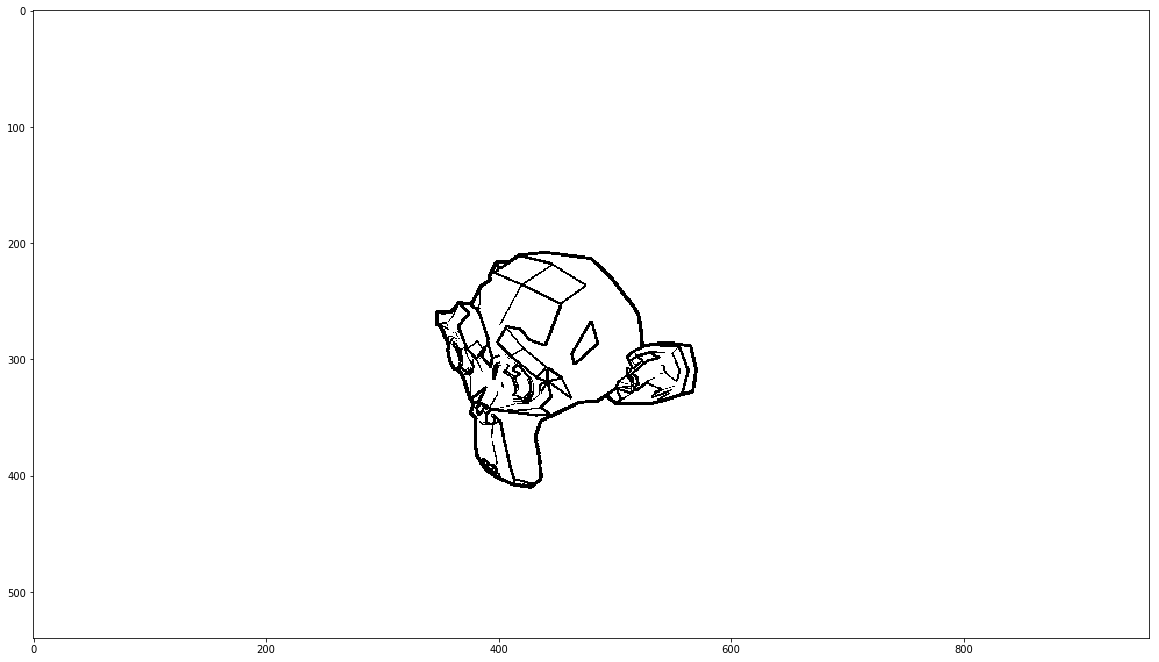

In [14]:
edge_monkey = filters.sobel(normal_monkey[:,:,0]) + filters.sobel(ao_monkey[:,:,0])
bin_edge_monkey = np.where(edge_monkey<0.1, 0, 1)
plt.figure(figsize=(20,20))
plt.imshow(ndimage.gaussian_filter(bin_edge_monkey, sigma=0.12), cmap = plt.cm.Greys)

In [95]:
def momentum_sketch(points):
    velocity = 0.1
    dwg = svgwrite.Drawing('momentum.svg')
    
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), rx=None, ry=None, fill='white'))

    gradline = dwg.linearGradient((0, 0), (0, 0), id="grad")
    gradline.add_stop_color(0.1, 'white')
    gradline.add_stop_color(1, 'black')
    
    dwg.defs.add(gradline)
    
    path = dwg.path(('M', points[0,0], points[0,1]), fill='none', stroke='black', stroke_linecap='round')
    for i in range(1, len(points)):
        velocity = 0.1
        currentPos = np.copy(points[i-1])
        print(currentPos)
        
        angle = np.rad2deg(np.arctan2([points[i-1][1], points[i][1]], [points[i-1][0], points[i][0]]))
        print(angle)
        while lessThan(points[i-1], currentPos, points[i]):
            currentPos = [currentPos[0]+( velocity*np.cos(angle[0]) ), currentPos[1]+( velocity*np.sin(angle[1]) )]
            print(currentPos)
            path.push(('L', currentPos[0], currentPos[1]))
            velocity = velocity + 0.2
            
        path.push(('M', points[i][0], points[i][1]))
        
    dwg.add(path)
        
    return dwg

def lessThan(startPos, currentPos, endPos):
    if np.linalg.norm(currentPos-startPos) < np.linalg.norm(endPos-startPos):
        return True
    else:
        return False

In [96]:
path_out = momentum_sketch(simplified_contours[0])
path_out.save()

[571.24235372 311.        ]
[28.56508432 28.4772461 ]
[571.1465508135418, 310.9798477350816]
[570.8591421088258, 310.91939094032637]
[570.3801276009659, 310.81862961573427]
[569.7095072899621, 310.67756376130535]
[571.49008639 310.        ]
[28.4772461  28.40007779]
[571.3921380060237, 309.9874587196848]
[571.0982928495758, 309.9498348787393]
[570.6085509221626, 309.88712847716346]
[569.9229122237841, 309.79933951495724]
[571.48169031 309.        ]
[28.40007779 28.33381746]
[571.382479848299, 308.9940551489851]
[571.0848484544701, 308.97622059594045]
[570.5887961314221, 308.946496340866]
[569.8943228791547, 308.9048823837618]
[571.21014285 308.        ]
[28.33381746 28.31686497]
[571.1103197157239, 307.9957481737718]
[570.8108503037338, 307.98299269508715]
[571.         307.66865892]
[28.31686497 28.27137293]
[570.9000904310202, 307.6689550146618]
[570.6003617240809, 307.6698432995001]
[570.100813879182, 307.6713237742306]
[570.84396324 307.        ]
[28.27137293 28.19542075]
[570.7439

[23.81208659 23.81961091]
[480.024754124107, 211.7294909363822]
[480.0990164964281, 211.43939472540185]
[480.2227871169632, 210.95590104043458]
[480.3960659857124, 210.27900988148042]
[479.         211.46004429]
[23.81961091 23.85212902]
[479.0254824304938, 211.3642251730504]
[479.1019297219752, 211.07676781003127]
[479.2293418744442, 210.5976722049994]
[479.4077188879008, 209.92693835795484]
[478.         211.34282295]
[23.85212902 23.89230628]
[478.02861286510586, 211.248230432103]
[478.1144514604235, 210.96445287839092]
[478.2575157859528, 210.49149028887072]
[478.4578058416939, 209.82934266354246]
[477.         211.30067938]
[23.89230628 23.93241273]
[477.0324384888146, 211.20746357059963]
[477.12975395525837, 210.92781614978247]
[477.2919463993313, 210.4617371150872]
[477.51901582103346, 209.80922646651382]
[476.         211.25640256]
[23.93241273 23.96568125]
[476.036205156217, 211.16444260080786]
[476.14482062486815, 210.88856273100205]
[476.32584640595337, 210.4287629479924]
[4

[31.60361161 31.71850399]
[384.09824387969707, 236.30154204700688]
[384.3929755187882, 236.3909365138638]
[384.8841949172734, 236.5399272919587]
[385.57190207515276, 236.74851438129153]
[383.         236.71652893]
[31.71850399 31.76816421]
[383.0954571627575, 236.75102882115246]
[383.38182865102993, 236.85452850775033]
[382.71652893 237.        ]
[31.76816421 31.89737452]
[382.8103892325032, 237.0463063047168]
[383.0919701531533, 237.1852252188672]
[383.56127168757007, 237.4167567424512]
[384.21829383575357, 237.7409008754688]
[382.40204757 238.        ]
[31.89737452 32.00475828]
[382.4906801071597, 238.05553898921139]
[382.7565777101787, 238.22215595684557]
[383.1997403818771, 238.49985090290255]
[382.         238.74420601]
[32.00475828 32.04959906]
[382.0831590083958, 238.80341683640358]
[382.33263603358324, 238.98104931986325]
[381.74420601 239.        ]
[32.04959906 32.17952851]
[381.82479185019923, 239.06915278117734]
[382.06654937504584, 239.27661112470938]
[382.46947858312353, 2

[375.5794142608865, 342.9006901205852]
[375.57716644849114, 342.6027604823408]
[375.5734200944989, 342.10621108526675]
[375.5681751989097, 341.41104192936314]
[375.        343.9741573]
[42.52905216 42.53316338]
[375.0117280795792, 343.87489647978816]
[374.9741573 344.       ]
[42.53316338 42.66013704]
[374.98629356728145, 343.9030751073921]
[375.0227023590135, 343.6123004295685]
[375.083383678567, 343.1276759665291]
[375.1683375259418, 342.44920171827397]
[374.39523068 345.        ]
[42.66013704 42.74410853]
[374.41983891231087, 344.9054805880402]
[374.49366361506384, 344.62192235216077]
[374.6167047863188, 344.1493252923617]
[374.7889624260757, 343.487689408643]
[374.37791323 346.        ]
[42.74410853 42.79606209]
[374.41056412389884, 345.90730368843725]
[374.5085168005593, 345.62921475374895]
[374.67177126166, 345.1657331959351]
[374.900327507201, 344.5168590149957]
[374.77757848 347.        ]
[42.79606209 42.79741823]
[374.8150937232051, 346.9073546498935]
[374.9276394668115, 346.6

[41.68238854 41.6104195 ]
[436.80769675065255, 388.9304069394498]
[436.60783439096144, 388.7216277577993]
[436.2747304581429, 388.37366245504836]
[435.80838495219706, 387.8865110311971]
[436.85487808 388.        ]
[41.6104195  41.53956543]
[436.7830671733467, 387.93566539386734]
[436.5676344615564, 387.74266157546936]
[436.2085799419059, 387.420988544806]
[435.7059036143952, 386.9706463018773]
[436.81574172 387.        ]
[41.53956543 41.47036171]
[436.7391841712465, 386.941113225511]
[436.5095115214081, 386.764452902044]
[436.12672377167746, 386.47001902959903]
[435.59082092205455, 386.057811608176]
[436.74866589 386.        ]
[41.47036171 41.40512378]
[436.66784295291677, 385.94650747421724]
[436.4253741299466, 385.786029896869]
[436.02125942499634, 385.51856726795535]
[435.455498838066, 385.1441195874762]
[436.61806188 385.        ]
[41.40512378 41.35231788]
[436.53357193913337, 384.9510415317876]
[436.2801021240302, 384.8041661271505]
[435.8576524321915, 384.5593737860886]
[435.2662

[491.95932124 333.        ]
[34.093491   34.08964631]
[491.86989555038474, 333.0450988792552]
[492.         332.97939618]
[34.08964631 34.03080426]
[491.91074703876103, 333.02966580512543]
[491.6429881550441, 333.18047467685943]
[491.1967233488493, 333.4318227964161]
[490.5719526201765, 333.7837101637954]
[493.         332.91848276]
[34.03080426 34.03278293]
[492.9135536876911, 332.9685812337603]
[492.6542147507643, 333.11887666346905]
[493.08399798 333.        ]
[34.03278293 34.05532372]
[492.99745237479226, 333.0481351090809]
[492.7378155441833, 333.19254043632344]
[492.3050874931684, 333.4332159817277]
[491.6992682217475, 333.77016174529365]
[494.         333.90167224]
[34.05532372 34.0578601 ]
[493.91234721183116, 333.94958487448343]
[493.6493888473246, 334.09332277552573]
[494.09832776 334.        ]
[34.0578601  34.08106484]
[494.01055316416114, 334.0458631306688]
[493.7472293790525, 334.1834525226752]
[493.3083564038714, 334.41276817601926]
[492.6939342386179, 334.73381009070096]